Total number of instances before removal: 17393
Total number of instances after removal: 13716
Number of test annotations for top 1%: 137
Optimal test features shape for top 1% entries: (137, 29)
Number of test annotations for remaining instances: 13582
Optimal test features shape for remaining instances: (13582, 29)


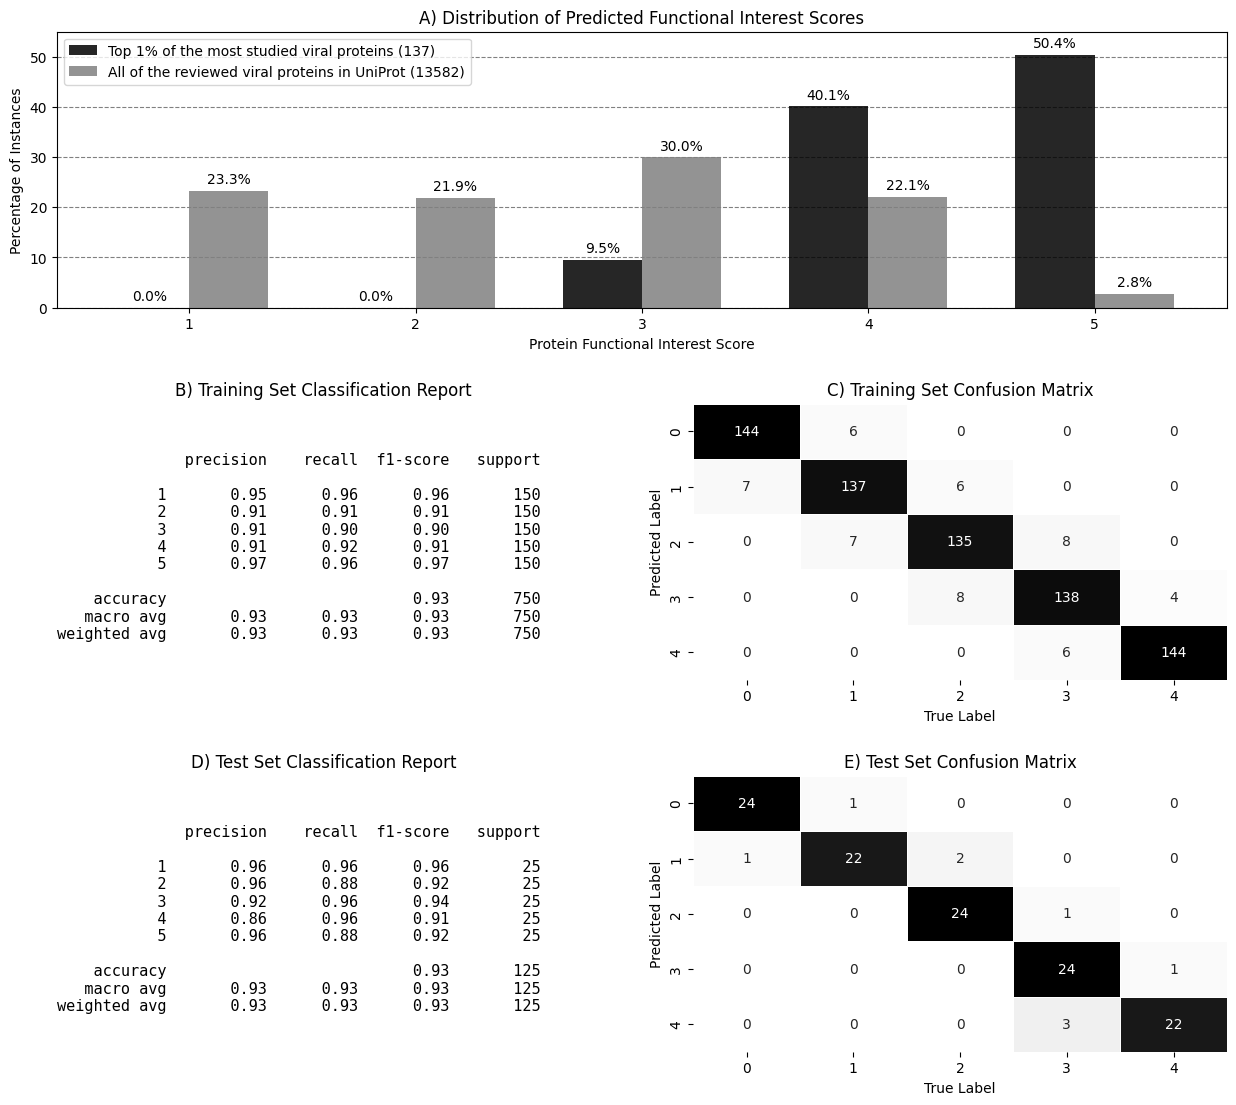

In [1]:
import os
import sys
import random
import warnings

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# Add the path to local modules
sys.path.append('../utils')
import utils
import protein_score

# Suppress warnings for clean output
warnings.simplefilter(action='ignore', category=UserWarning)

# Set the current working directory
current_dir = os.getcwd()

# Paths to required directories and files
json_folder_path = os.path.join(current_dir, '../utils/uniprot/')
scaler_path = os.path.join(current_dir, '../utils/ml/scaler.pkl')
selector_path = os.path.join(current_dir, '../utils/ml/selector.pkl')
classifier_path = os.path.join(current_dir, '../utils/ml/classifier.pkl')

# Load pre-trained models and scalers
scaler = joblib.load(scaler_path)
selector = joblib.load(selector_path)
classifier = joblib.load(classifier_path)

# Load training annotations
train_annotations_path = os.path.join(current_dir, '../utils/ml/train.csv')
train_annotations = utils.load_annotations(train_annotations_path)

# Generate training data
X_train, y_train, ids_train, df_train = protein_score.generate_data_from_json(
    train_annotations, json_folder_path
)

# Scale and select features for training data
X_train_scaled = scaler.transform(X_train)
X_train_selected = selector.transform(X_train_scaled)

# Set up cross-validation strategy
stratified_kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Perform cross-validation predictions on training data
y_train_pred = cross_val_predict(
    classifier, X_train_selected, y_train, cv=stratified_kfold, n_jobs=10
)

# Refine predictions based on specific rules
y_train_pred = protein_score.refine_predictions(y_train_pred, df_train)

# Generate classification report and confusion matrix for training data
train_classification_report = classification_report(y_train, y_train_pred)
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)

# Load test annotations
test_annotations_path = os.path.join(current_dir, '../utils/ml/test.csv')
test_annotations = utils.load_annotations(test_annotations_path)

# Generate test data
X_test, y_test, ids_test, df_test = protein_score.generate_data_from_json(
    test_annotations, json_folder_path
)

# Scale and select features for test data
X_test_scaled = scaler.transform(
    protein_score.adjust_test_data(df_train, df_test)
)
X_test_selected = selector.transform(X_test_scaled)

# Predict and refine test labels
y_test_pred = classifier.predict(X_test_selected)
y_test_pred = protein_score.refine_predictions(y_test_pred, df_test)

# Generate classification report and confusion matrix for test data
test_classification_report = classification_report(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

# Verbosity level (0 = minimal output)
verbosity_level = 0

# Path to the Excel file containing additional data
excel_file_path = os.path.join(
    current_dir, 'uniprotkb_taxonomy_id_10239_AND_reviewe_2024_07_02.xlsx'
)

# Load Excel data while suppressing UserWarnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    excel_data = pd.read_excel(excel_file_path)

# Total instances before filtering
total_instances_before_filter = excel_data.shape[0]
print(f"Total number of instances before removal: {total_instances_before_filter}")

# Filter out specific organisms and already-used training entries
excel_data = excel_data[
    ~excel_data['Organism'].str.contains("phage|phaga|particle", case=False, na=False)
]
excel_data = excel_data[~excel_data['Entry'].isin(train_annotations.keys())]

# Total instances after filtering
total_instances_after_filter = excel_data.shape[0]
print(f"Total number of instances after removal: {total_instances_after_filter}")

# Calculate publication count for each entry
excel_data['Publication Count'] = excel_data['PubMed ID'].apply(
    lambda x: len(str(x).split('; '))
)

# Identify the top 1% entries based on publication count
top_one_percent_threshold = int(total_instances_after_filter * 0.01)
top_one_percent_entries = excel_data.sort_values(
    by='Publication Count', ascending=False
).head(top_one_percent_threshold)

# Summary of the top 1% entries
top_one_percent_summary = top_one_percent_entries[
    ['Entry', 'Entry Name', 'Gene Names', 'Organism', 'Publication Count']
]

# Display detailed information if verbosity is enabled
if verbosity_level != 0:
    for _, row in top_one_percent_summary.iterrows():
        print(
            f"Entry: {row['Entry']}, Organism: {row['Organism']}, "
            f"Publication Count: {row['Publication Count']}"
        )

# List of top 1% entries not in training data and with corresponding JSON files
top_one_percent_ids = top_one_percent_entries['Entry'].tolist()
json_files_in_folder = os.listdir(json_folder_path)
json_files_in_folder = [file for file in json_files_in_folder if file.endswith('.json')]
json_files_in_folder = [os.path.splitext(file)[0] for file in json_files_in_folder]

test_annotations_top_one_percent = {
    entry_id: -1
    for entry_id in top_one_percent_ids
    if entry_id not in train_annotations.keys() and entry_id in json_files_in_folder
}
print(
    "Number of test annotations for top 1%: "
    f"{len(test_annotations_top_one_percent)}"
)

# Generate and adjust test data for top 1% entries
(
    X_test_top_one_percent,
    y_test_top_one_percent,
    ids_test_top_one_percent,
    df_test_top_one_percent,
) = protein_score.generate_data_from_json(
    test_annotations_top_one_percent, json_folder_path
)
X_test_adjusted_top_one_percent = protein_score.adjust_test_data(
    df_train, df_test_top_one_percent
)
X_test_scaled_top_one_percent = scaler.transform(X_test_adjusted_top_one_percent)
X_test_selected_top_one_percent = selector.transform(X_test_scaled_top_one_percent)
print(
    "Optimal test features shape for top 1% entries:",
    X_test_selected_top_one_percent.shape,
)

# Classify and refine predictions for top 1% entries
y_pred_prob_top_one_percent = classifier.predict_proba(X_test_selected_top_one_percent)
y_pred_classes_top_one_percent = np.argmax(y_pred_prob_top_one_percent, axis=1) + 1
final_y_pred_top_one_percent = protein_score.refine_predictions(
    y_pred_classes_top_one_percent, df_test_top_one_percent
)

# Handle other instances not in the top 1% for further predictions
all_json_files = [
    os.path.splitext(file)[0]
    for file in os.listdir(json_folder_path)
    if file.endswith('.json')
]
remaining_json_files = [
    file
    for file in all_json_files
    if file not in train_annotations.keys()
    and file not in test_annotations_top_one_percent.keys()
]
selected_json_files = random.sample(
    remaining_json_files, len(remaining_json_files)
)  # All files not already processed

test_annotations_remaining = {entry_id: -1 for entry_id in selected_json_files}
print(
    "Number of test annotations for remaining instances: "
    f"{len(test_annotations_remaining)}"
)

# Generate and adjust test data for remaining instances
(
    X_test_remaining,
    y_test_remaining,
    ids_test_remaining,
    df_test_remaining,
) = protein_score.generate_data_from_json(
    test_annotations_remaining, json_folder_path
)
X_test_adjusted_remaining = protein_score.adjust_test_data(df_train, df_test_remaining)
X_test_scaled_remaining = scaler.transform(X_test_adjusted_remaining)
X_test_selected_remaining = selector.transform(X_test_scaled_remaining)
print(
    "Optimal test features shape for remaining instances:",
    X_test_selected_remaining.shape,
)

# Classify and refine predictions for remaining instances
y_pred_prob_remaining = classifier.predict_proba(X_test_selected_remaining)
y_pred_classes_remaining = np.argmax(y_pred_prob_remaining, axis=1) + 1
final_y_pred_remaining = protein_score.refine_predictions(
    y_pred_classes_remaining, df_test_remaining
)

# Set up a grid for subplots
fig = plt.figure(figsize=(13, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

# Calculate distribution of predicted classes for top 1% and remaining instances
distribution_top_one_percent = np.bincount(final_y_pred_top_one_percent)[1:]
distribution_remaining = np.bincount(final_y_pred_remaining)[1:]

# Calculate percentages for each class
percentages_top_one_percent = (
    distribution_top_one_percent / distribution_top_one_percent.sum() * 100
)
percentages_remaining = (
    distribution_remaining / distribution_remaining.sum() * 100
)

# Bar chart for distribution of predicted functional interest scores
score_labels = ['1', '2', '3', '4', '5']
x_positions = np.arange(len(score_labels))
bar_width = 0.35

ax0 = plt.subplot(gs[0, :])  # Span across all columns in the first row
rects1 = ax0.bar(
    x_positions - bar_width / 2,
    percentages_top_one_percent,
    bar_width,
    label=(
        f"Top 1% of the most studied viral proteins "
        f"({len(final_y_pred_top_one_percent)})"
    ),
    color='black',
    alpha=0.85,
)
rects2 = ax0.bar(
    x_positions + bar_width / 2,
    percentages_remaining,
    bar_width,
    label=(
        f"All of the reviewed viral proteins in UniProt "
        f"({len(final_y_pred_remaining)})"
    ),
    color='grey',
    alpha=0.85,
)
ax0.set_title('A) Distribution of Predicted Functional Interest Scores')
ax0.set_ylabel('Percentage of Instances')
ax0.set_xlabel('Protein Functional Interest Score')
ax0.set_xticks(x_positions)
ax0.set_xticklabels(score_labels)
ax0.legend()
ax0.set_axisbelow(True)
ax0.yaxis.grid(True, color='gray', linestyle='dashed')

# Properties for the text boxes
props = dict(boxstyle='square', pad=0.5, facecolor='white', alpha=1, linewidth=0)

# Text box for train classification report
ax1 = plt.subplot(gs[1, 0])
ax1.text(
    0.0,
    0.45,
    train_classification_report,
    transform=ax1.transAxes,
    fontsize=11,
    verticalalignment='center',
    fontname='monospace',
    bbox=props,
)
ax1.set_title("B) Training Set Classification Report")
ax1.axis('off')

# Heatmap for train confusion matrix
ax2 = plt.subplot(gs[1, 1])
sns.heatmap(
    train_confusion_matrix,
    annot=True,
    fmt="d",
    linewidths=0.5,
    ax=ax2,
    cmap='Greys',
    cbar=False,
)
ax2.set_title("C) Training Set Confusion Matrix")
ax2.set_xlabel("True Label")
ax2.set_ylabel("Predicted Label")

# Text box for test classification report
ax3 = plt.subplot(gs[2, 0])
ax3.text(
    0.0,
    0.45,
    test_classification_report,
    transform=ax3.transAxes,
    fontsize=11,
    verticalalignment='center',
    fontname='monospace',
    bbox=props,
)
ax3.set_title("D) Test Set Classification Report")
ax3.axis('off')

# Heatmap for test confusion matrix
ax4 = plt.subplot(gs[2, 1])
sns.heatmap(
    test_confusion_matrix,
    annot=True,
    fmt="d",
    linewidths=0.5,
    ax=ax4,
    cmap='Greys',
    cbar=False,
)
ax4.set_title("E) Test Set Confusion Matrix")
ax4.set_xlabel("True Label")
ax4.set_ylabel("Predicted Label")

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height.

    Parameters
    ----------
    rects : list
        List of bar containers.
    ax : matplotlib.axes.Axes
        The axes on which to place the labels.
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height:.1f}%',
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # Offset text by 3 points vertically
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=10,
        )

# Add percentage labels to the bar chart
ax0.set_ylim(0, 55)
autolabel(rects1, ax0)
autolabel(rects2, ax0)

# Adjust layout and save the figure
plt.tight_layout(pad=2.5)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
plt.savefig('protein_score_figure.pdf', dpi=300)
plt.show()


In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_selected)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import SpectralClustering

# Nombre de clusters (idéalement égal ou estimé à partir du nombre de classes)
n_clusters = len(np.unique(y_train))

# Clustering hiérarchique
agg = AgglomerativeClustering(n_clusters=n_clusters, metric='manhattan', linkage='average')
clustering = SpectralClustering(n_clusters=n_clusters, random_state=0)
cluster_labels = agg.fit_predict(X_train)

y_train_zero = y_train - 1  # Maintenant y_train_zero va de 0 à 4
ari = adjusted_rand_score(y_train_zero, cluster_labels)
print("ARI:", ari)



ARI: 0.0217300318932735


In [35]:
X_train.max()

np.float64(1.0)

In [40]:
for i, v in enumerate(y_train_zero):
    print(v, cluster_labels[i])

0 4
0 4
0 4
0 4
0 1
1 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
1 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 1
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 1
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 1
0 4
0 4
0 4
0 4
0 4
0 1
0 1
0 4
0 4
0 4
0 4
0 4
0 4
1 4
1 4
1 4
1 1
1 1
1 4
1 4
1 4
1 4
1 4
1 4
1 1
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 1
1 1
1 4
1 4
1 1
1 4
1 1
1 4
1 1
1 1
1 4
1 4
1 4
1 4
1 1
1 1
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 1
1 4
1 1
1 4
1 4
1 1
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 4
1 1
1 4
1 1
1 4
1 4
1 4
1 4
1 1
1 4
1 1
1 4
1 4
1 4
1 1
1 4
1 4
1 1
1 4
1 4
1 1
1 1
1 4
1 1
1 1
1 4
1 4


In [38]:
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

# cluster_labels : étiquettes prédites par votre clustering
# y_train : classes réelles

ari = adjusted_rand_score(y_train, cluster_labels)
ami = adjusted_mutual_info_score(y_train, cluster_labels)
h = homogeneity_score(y_train, cluster_labels)
c = completeness_score(y_train, cluster_labels)
v = v_measure_score(y_train, cluster_labels)

print("Adjusted Rand Index (ARI):", ari)
print("Adjusted Mutual Information (AMI):", ami)
print("Homogénéité:", h)
print("Complétude:", c)
print("V-mesure:", v)


Adjusted Rand Index (ARI): 0.0217300318932735
Adjusted Mutual Information (AMI): 0.07670472308542914
Homogénéité: 0.061324395903420016
Complétude: 0.1468563185027571
V-mesure: 0.08651978203140033
